<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/classification/Classification_NO_kfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


#Load data

In [3]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
public_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
PA_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
public_labels = df_train.Histology

In [0]:
PA_labels = df_test.Histology

#Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train_big, X_test, y_train_big, y_test = train_test_split(public_data, public_labels, test_size=13, stratify=public_labels, random_state=1)

#Train Validation Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train_big, y_train_big, test_size=13, stratify=y_train_big, random_state=2)                                                         

#Z score dei dati

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data_stand = scaler.fit_transform(X_train)
val_data_stand = scaler.transform(X_val)
test_data_stand = scaler.transform(X_test)

#LDA

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [0]:
lda = LinearDiscriminantAnalysis(n_components=3)

In [21]:
train_data_stand_lda = lda.fit(train_data_stand, y_train).transform(train_data_stand)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(107, 3 - 1) = 2 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


In [22]:
train_data_stand_lda.shape

(105, 2)

In [0]:
val_data_stand_lda = lda.transform(val_data_stand)

In [0]:
test_data_stand_lda = lda.transform(test_data_stand)

##Z-score dopo LDA

In [0]:
from sklearn.preprocessing import StandardScaler
scaler_2 = StandardScaler()
train_data_stand_lda = scaler_2.fit_transform(train_data_stand_lda)
val_data_stand_lda = scaler_2.transform(val_data_stand_lda)
test_data_stand_lda = scaler_2.transform(test_data_stand_lda)

##Vettorizzare i label

In [0]:
word_index={'adenocarcinoma':0, 'large cell':1, 'squamous cell carcinoma':2}

In [0]:
train_labels_dec = [word_index[label] for label in y_train]

In [0]:
val_labels_dec = [word_index[label] for label in y_val]

In [0]:
test_labels_dec = [word_index[label] for label in y_test]

In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_val_labels = to_categorical(val_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

##Building Network

In [0]:
import keras
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.optimizers import SGD

In [0]:
from keras import layers

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(8, activation='relu', input_shape=(2,), kernel_regularizer=regularizers.l2(l=0.1)))
  model.add(layers.Dense(7, activation='relu'))
  #model.add(layers.Dropout(rate=0.2))

  model.add(layers.Dense(3, activation='softmax'))

  sgd = SGD(lr=0.001, momentum=0.9)
  adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau('val_loss', patience=10, verbose=1, min_lr=0.0001)

In [41]:
one_hot_val_labels.shape

(13, 3)

In [192]:
num_epochs = 1500

model = build_model()
history = model.fit(train_data_stand_lda, one_hot_train_labels, validation_data=(val_data_stand_lda, one_hot_val_labels), 
                      epochs= num_epochs, batch_size=105, callbacks=[red_lr])
  

acc_history = history.history['acc']
loss_history = history.history['loss']
acc_val_history = history.history['val_acc']
loss_val_history = history.history['val_loss']


NameError: ignored

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

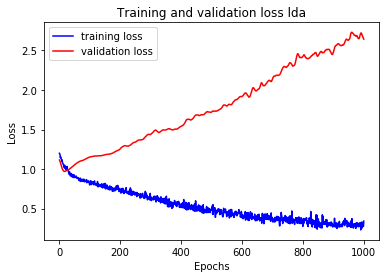

In [191]:
plt.plot(epochs, loss_history, 'b', label='training loss')
plt.plot(epochs, loss_val_history, 'r', label='validation loss')
plt.title('Training and validation loss lda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

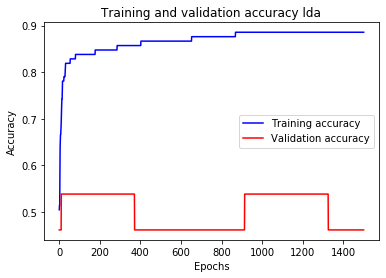

In [56]:
plt.plot(epochs, acc_history, 'b', label='Training accuracy')
plt.plot(epochs, acc_val_history, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy lda')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [57]:
 model = build_model()
 model.fit(train_data_stand_lda, one_hot_train_labels, epochs= num_epochs, batch_size=105, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_lda, one_hot_test_labels)
  

Epoch 1/1500
105/105 [==============================] - 0s 2ms/step - loss: 1.4181 - acc: 0.4667
Epoch 2/1500
105/105 [==============================] - 0s 17us/step - loss: 1.4174 - acc: 0.4667
Epoch 3/1500
105/105 [==============================] - 0s 15us/step - loss: 1.4159 - acc: 0.4667
Epoch 4/1500
105/105 [==============================] - 0s 16us/step - loss: 1.4137 - acc: 0.4667
Epoch 5/1500
105/105 [==============================] - 0s 14us/step - loss: 1.4110 - acc: 0.4667
Epoch 6/1500
105/105 [==============================] - 0s 15us/step - loss: 1.4079 - acc: 0.4667
Epoch 7/1500
105/105 [==============================] - 0s 21us/step - loss: 1.4042 - acc: 0.4667
Epoch 8/1500
105/105 [==============================] - 0s 18us/step - loss: 1.4002 - acc: 0.4667
Epoch 9/1500
105/105 [==============================] - 0s 19us/step - loss: 1.3959 - acc: 0.4667
Epoch 10/1500
105/105 [==============================] - 0s 17us/step - loss: 1.3913 - acc: 0.4667
Epoch 11/1500
105/10

In [58]:
model.metrics_names

['loss', 'acc']

In [59]:
test_acc


0.4615384638309479

Si comporta molto bene in training e in validation ma si comporta male in test

#PCA

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9, svd_solver='full')
pca.fit(train_data_stand)
train_data_stand_pca = pca.transform(train_data_stand)
val_data_stand_pca = pca.transform(val_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)
train_data_stand_pca.shape

(105, 9)

##Z-score dopo PCA

In [0]:
from sklearn.preprocessing import StandardScaler
scaler_2 = StandardScaler()
train_data_stand_pca = scaler_2.fit_transform(train_data_stand_pca)
val_data_stand_pca = scaler_2.transform(val_data_stand_pca)
test_data_stand_pca = scaler_2.transform(test_data_stand_pca)

##Vettorizzare i label

In [0]:
word_index={'adenocarcinoma':0, 'large cell':1, 'squamous cell carcinoma':2}

In [0]:
train_labels_dec = [word_index[label] for label in y_train]

In [0]:
val_labels_dec = [word_index[label] for label in y_val]

In [0]:
test_labels_dec = [word_index[label] for label in y_test]

In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_val_labels = to_categorical(val_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

##Building Network

In [0]:
import keras
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.optimizers import SGD

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(30, activation='relu', input_shape=(9,), kernel_regularizer=regularizers.l2(l=0.001)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(30, activation='relu', kernel_regularizer=regularizers.l2(l=0.001)))
  #model.add(layers.Dropout(0.1))

  model.add(layers.Dense(3, activation='softmax'))

  sgd = SGD(lr=0.01, momentum=0.9)
  adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau('val_loss', patience=10, verbose=1, min_lr=0.0001)
#usandolo la loss non scende anche se non agisce, COME MAI????
#non usandolo e non variando nient'altro la loss scende molto rapidamente

In [157]:

one_hot_val_labels.shape

(13, 3)

In [196]:
num_epochs = 1000

model = build_model()
history = model.fit(train_data_stand_pca, one_hot_train_labels, validation_data=(val_data_stand_pca, one_hot_val_labels), 
                      epochs= num_epochs, batch_size=105)
  

acc_history = history.history['acc']
loss_history = history.history['loss']
acc_val_history = history.history['val_acc']
loss_val_history = history.history['val_loss']


Train on 105 samples, validate on 13 samples
Epoch 1/1000
105/105 [==============================] - 3s 27ms/step - loss: 1.2288 - acc: 0.3714 - val_loss: 1.1590 - val_acc: 0.5385
Epoch 2/1000
105/105 [==============================] - 0s 53us/step - loss: 1.1973 - acc: 0.3524 - val_loss: 1.1482 - val_acc: 0.5385
Epoch 3/1000
105/105 [==============================] - 0s 47us/step - loss: 1.1665 - acc: 0.4190 - val_loss: 1.1378 - val_acc: 0.5385
Epoch 4/1000
105/105 [==============================] - 0s 45us/step - loss: 1.1567 - acc: 0.4476 - val_loss: 1.1277 - val_acc: 0.5385
Epoch 5/1000
105/105 [==============================] - 0s 48us/step - loss: 1.1307 - acc: 0.4667 - val_loss: 1.1186 - val_acc: 0.5385
Epoch 6/1000
105/105 [==============================] - 0s 46us/step - loss: 1.1641 - acc: 0.3524 - val_loss: 1.1103 - val_acc: 0.5385
Epoch 7/1000
105/105 [==============================] - 0s 44us/step - loss: 1.1336 - acc: 0.4476 - val_loss: 1.1021 - val_acc: 0.5385
Epoch 8/10

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

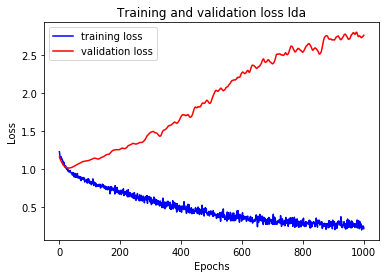

In [197]:
plt.plot(epochs, loss_history, 'b', label='training loss')
plt.plot(epochs, loss_val_history, 'r', label='validation loss')
plt.title('Training and validation loss lda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

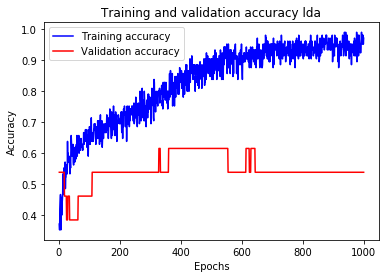

In [198]:
plt.plot(epochs, acc_history, 'b', label='Training accuracy')
plt.plot(epochs, acc_val_history, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy lda')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [199]:
 model = build_model()
 model.fit(train_data_stand_pca, one_hot_train_labels, epochs= num_epochs, batch_size=105, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_pca, one_hot_test_labels)
  

Epoch 1/1000
105/105 [==============================] - 3s 25ms/step - loss: 1.3937 - acc: 0.1905
Epoch 2/1000
105/105 [==============================] - 0s 53us/step - loss: 1.4110 - acc: 0.1810
Epoch 3/1000
105/105 [==============================] - 0s 29us/step - loss: 1.3383 - acc: 0.2571
Epoch 4/1000
105/105 [==============================] - 0s 36us/step - loss: 1.3043 - acc: 0.2381
Epoch 5/1000
105/105 [==============================] - 0s 40us/step - loss: 1.3153 - acc: 0.2286
Epoch 6/1000
105/105 [==============================] - 0s 38us/step - loss: 1.3610 - acc: 0.2381
Epoch 7/1000
105/105 [==============================] - 0s 35us/step - loss: 1.2880 - acc: 0.1810
Epoch 8/1000
105/105 [==============================] - 0s 32us/step - loss: 1.3193 - acc: 0.2286
Epoch 9/1000
105/105 [==============================] - 0s 29us/step - loss: 1.2666 - acc: 0.2381
Epoch 10/1000
105/105 [==============================] - 0s 29us/step - loss: 1.2252 - acc: 0.2952
Epoch 11/1000
105/1

In [0]:
model.metrics_names

['loss', 'acc']

In [200]:
test_acc


0.4615384638309479

Si comporta molto bene in training e in validation ma si comporta male in test

#NO FEATURES SELECTION

Remove correlated features manually